In [1]:
import os
import bz2
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
from GeoBases import GeoBase
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

---
# First exercise
> *Count the number of lines in Python for each file*

In [2]:
data_dir = "/data/storage/projects/TravelAudience/"
data_files = ['bookings.csv.bz2', 'searches.csv.bz2']

We count the lines without the need of creating a decompressed file:

In [3]:
for filename in data_files:
    filepath = os.path.join(data_dir, filename)
    with bz2.BZ2File(filepath, "r") as myfile:
        count = sum(1 for line in myfile)
        print("Number of lines in file %s: \t %i" %(filename,count))

Number of lines in file bookings.csv.bz2: 	 10000011
Number of lines in file searches.csv.bz2: 	 20390199


---
# Second exercise
> *Top 10 arrival airports in the world in 2013 (using the bookings file)*

First, we read only 2 lines to better understand the meaning and format of the features:

In [4]:
filepath = os.path.join(data_dir, data_files[0])
dftemp = pd.read_csv(filepath, sep='^', compression='bz2', nrows=2)
dftemp.head(2)

,act_date,source,pos_ctry,pos_iata,pos_oid,rloc,cre_date,duration,distance,dep_port,...,route,carrier,bkg_class,cab_class,brd_time,off_time,pax,year,month,oid
0,2013-03-05 00:00:00,1A,DE,a68dd7ae953c8acfb187a1af2dcbe123,1a11ae49fcbf545fd2afc1a24d88d2b7,ea65900e72d71f4626378e2ebd298267,2013-02-22 00:00:00,1708,0,ZRH,...,LHRZRH,VI,T,Y,2013-03-07 08:50:00,2013-03-07 11:33:37,-1,2013,3,NULL
1,2013-03-26 00:00:00,1A,US,e612b9eeeee6f17f42d9b0d3b79e75ca,7437560d8f276d6d05eeb806d9e7edee,737295a86982c941f1c2da9a46a14043,2013-03-26 00:00:00,135270,0,SAL,...,SALATLCLT,NV,L,Y,2013-04-12 13:04:00,2013-04-12 22:05:40,1,2013,3,NULL


In [5]:
print dftemp.columns.values

['act_date           ' 'source' 'pos_ctry' 'pos_iata' 'pos_oid  '
 'rloc          ' 'cre_date           ' 'duration' 'distance' 'dep_port'
 'dep_city' 'dep_ctry' 'arr_port' 'arr_city' 'arr_ctry' 'lst_port'
 'lst_city' 'lst_ctry' 'brd_port' 'brd_city' 'brd_ctry' 'off_port'
 'off_city' 'off_ctry' 'mkt_port' 'mkt_city' 'mkt_ctry' 'intl'
 'route          ' 'carrier' 'bkg_class' 'cab_class' 'brd_time           '
 'off_time           ' 'pax' 'year' 'month' 'oid      ']


**We want to filter only the 2013 flights. To do that, we will use the feature *brd_time* ** instead of *act_date*, *cre_date* or *year*. After exploring the data, it seems that only *brd_time* (or *off_time*) contains information on the year that the flight took place. Features like *act_date*, *cre_date* and *year* are probably the date of the booking, not the flight.

Now we read all the file, but only the specific columns we need (*act_date* and *dep_port* will only be used in Ex.4):

In [6]:
sel_cols = ['act_date           ', 'dep_port', 'arr_port', 'brd_time           ', 'pax']
dfB = pd.read_csv(filepath, sep='^', usecols=sel_cols, compression='bz2')
dfB.columns = [col.strip() for col in sel_cols] # removes white spaces in column names
print("total of %i rows, %i columns" % (dfB.shape[0],dfB.shape[1]))
dfB.head()

total of 10000010 rows, 5 columns


,act_date,dep_port,arr_port,brd_time,pax
0,2013-03-05 00:00:00,ZRH,LHR,2013-03-07 08:50:00,-1
1,2013-03-26 00:00:00,SAL,CLT,2013-04-12 13:04:00,1
2,2013-03-26 00:00:00,SAL,CLT,2013-07-15 07:00:00,1
3,2013-03-26 00:00:00,AKL,SVO,2013-04-24 23:59:00,1
4,2013-03-26 00:00:00,AKL,SVO,2013-05-14 20:15:00,1


In [7]:
# percentage of null data in dataset:
print("\n***** Columns with NULL data:\n")
n_cols_notnull = 0
for col in sorted(list(dfB.columns)):
    percent_null = float(dfB[col].isnull().sum()) / dfB.shape[0] * 100
    if percent_null > 0:
        print("{:15s}   {:.5f}%".format(col, percent_null))
    else:
        n_cols_notnull += 1
print("\n***** The other %i columns have NO NULL values :)\n" % n_cols_notnull)


***** Columns with NULL data:

pax               0.00001%

***** The other 4 columns have NO NULL values :)



In [8]:
# we can safely drop the row with NaN:
dfB = dfB.dropna()
# from date-time to date:
dfB['brd_time'] = dfB['brd_time'].apply(lambda x: x.split(' ')[0])
dfB['act_date'] = dfB['act_date'].apply(lambda x: x.split(' ')[0])
# year of flight and year of search:
dfB['year_bt'] = dfB['brd_time'].apply(lambda x: x.split('-')[0])
dfB['year_ad'] = dfB['act_date'].apply(lambda x: x.split('-')[0])
# change dtypes:
dfB['year_bt'] = dfB['year_bt'].astype('category')
dfB['year_ad'] = dfB['year_ad'].astype('category')
dfB['pax'] = dfB['pax'].astype(np.int16)

Take a look at numerical features:

In [9]:
dfB['pax'].describe()

count    10000009.000000
mean            0.490880
std             2.199173
min           -90.000000
25%            -1.000000
50%             1.000000
75%             1.000000
max            99.000000
Name: pax, dtype: float64

Take a look at categorical features:

In [10]:
Categ_cols = ['dep_port', 'arr_port', 'year_bt', 'year_ad']
for col in Categ_cols:
    n_un = len(dfB[col].unique())
    print '****************\n Feature: ',col,'\n****************'
    print 'Number of uniques:',n_un
    print 'Categories    Counts\n----------    ------'
    if n_un>10:
        print pd.value_counts(dfB[col])[:10],'\n (there are other %i categories not shown)' % (n_un-10)
    else:
        print pd.value_counts(dfB[col])
    print '\n'

****************
 Feature:  dep_port 
****************
Number of uniques: 2147
Categories    Counts
----------    ------
LHR         268410
JFK         167800
CDG         160950
LAX         154620
FRA         131310
ORD         119070
SYD         114410
MAD         112570
TLV         110540
DXB         110370
Name: dep_port, dtype: int64 
 (there are other 2137 categories not shown)


****************
 Feature:  arr_port 
****************
Number of uniques: 2274
Categories    Counts
----------    ------
LHR         215551
JFK         158930
CDG         149390
LAX         143220
DXB         135640
BKK         130420
MIA         117820
SFO         110970
MNL         109530
ORD          99750
Name: arr_port, dtype: int64 
 (there are other 2264 categories not shown)


****************
 Feature:  year_bt 
****************
Number of uniques: 3
Categories    Counts
----------    ------
2013    9357539
2014     641940
2012        530
dtype: int64


****************
 Feature:  year_ad 
*******

Sum number of persons booked on 2013 flights grouped by arrival airport, and keep **the top 10 arrival airports**:

In [11]:
top10_airp = dfB[dfB['year_bt']=='2013'].groupby(['arr_port'])['pax'].sum()
top10_airp = top10_airp.sort_values(ascending=False).head(10).to_frame().reset_index()

In [12]:
# remove unnecessary columns:
dfB.drop(['pax','year_bt','year_ad'], axis=1, inplace=True)

**Plot** the top 10 arrival airports of 2013:

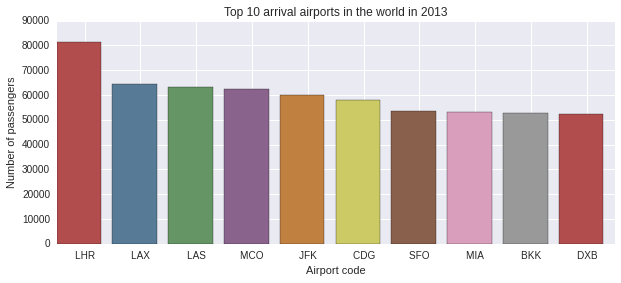

In [13]:
fig, ax = plt.subplots(figsize=(10,4))
x = np.arange(10)
ax.bar(x, top10_airp.pax, color=sns.color_palette("Set1", 10, desat=.5))
ax.set_xticks(x + 0.5)
ax.set_xticklabels(top10_airp.arr_port)
ax.set_xlabel("Airport code")
ax.set_ylabel("Number of passengers")
ax.set_title("Top 10 arrival airports in the world in 2013")

We enrich the results with the **airport and city names** from GeoBase:

In [14]:
# remove whitespaces in beggining/end of string
top10_airp['arr_port'] = top10_airp['arr_port'].apply(lambda x: x.strip())
# load airport data from GeoBase:
geo_o = GeoBase(data='ori_por', verbose=False)
# new column with the name of the airport:
top10_airp['airp_name'] = top10_airp.apply(lambda x: geo_o.get(x['arr_port'], 'name'), axis=1)
# new column with the name of the city:
top10_airp['city'] = top10_airp.apply(lambda x: geo_o.get(x['arr_port'], 'city_name_ascii'), axis=1)
top10_airp.index += 1 # so the top 10 starts with 1 instead of 0

And **print the results** in the standard output:

In [15]:
top10_airp

,arr_port,pax,airp_name,city
1,LHR,81449,London Heathrow Airport,London
2,LAX,64240,Los Angeles International Airport,Los Angeles
3,LAS,63190,Mc Carran International Airport,Las Vegas
4,MCO,62300,Orlando International Airport,Orlando
5,JFK,60090,John F Kennedy International Airport,New York City
6,CDG,58100,Paris - Charles-de-Gaulle,Paris
7,SFO,53710,San Francisco International Airport,San Francisco
8,MIA,53020,Miami International Airport,Miami
9,BKK,52670,Suvarnabhumi,Bangkok
10,DXB,52250,Dubai International Airport,Dubai


---
# Third exercise
> *Plot the monthly number of searches for flights arriving at Málaga, Madrid or Barcelona*


In [16]:
filepath = os.path.join(data_dir, data_files[1])
dftemp = pd.read_csv(filepath, sep='^', compression='bz2', nrows=2)
dftemp.head(2)

,Date,Time,TxnCode,OfficeID,Country,Origin,Destination,RoundTrip,NbSegments,Seg1Departure,...,Seg6Arrival,Seg6Date,Seg6Carrier,Seg6BookingCode,From,IsPublishedForNeg,IsFromInternet,IsFromVista,TerminalID,InternetOffice
0,2013-01-01,20:25:57,MPT,624d8c3ac0b3a7ca03e3c167e0f48327,DE,TXL,AUH,1,2,TXL,...,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,FRA
1,2013-01-01,10:15:33,MPT,b0af35b31588dc4ab06d5cf2986e8e02,MD,ATH,MIL,0,1,ATH,...,NaN,NaN,NaN,NaN,1ASIWS,0,0,0,d41d8cd98f00b204e9800998ecf8427e,KIV


In [17]:
print(dftemp.columns.values)

['Date' 'Time' 'TxnCode' 'OfficeID' 'Country' 'Origin' 'Destination'
 'RoundTrip' 'NbSegments' 'Seg1Departure' 'Seg1Arrival' 'Seg1Date'
 'Seg1Carrier' 'Seg1BookingCode' 'Seg2Departure' 'Seg2Arrival' 'Seg2Date'
 'Seg2Carrier' 'Seg2BookingCode' 'Seg3Departure' 'Seg3Arrival' 'Seg3Date'
 'Seg3Carrier' 'Seg3BookingCode' 'Seg4Departure' 'Seg4Arrival' 'Seg4Date'
 'Seg4Carrier' 'Seg4BookingCode' 'Seg5Departure' 'Seg5Arrival' 'Seg5Date'
 'Seg5Carrier' 'Seg5BookingCode' 'Seg6Departure' 'Seg6Arrival' 'Seg6Date'
 'Seg6Carrier' 'Seg6BookingCode' 'From' 'IsPublishedForNeg'
 'IsFromInternet' 'IsFromVista' 'TerminalID' 'InternetOffice']


To extract the month of the search we use the feature *Date*.
The feature *Seg1Date* will only be used afterwards.

In [18]:
sel_cols = ['Date', 'Origin', 'Destination', 'Seg1Date']
dfS = pd.read_csv(filepath, sep='^', usecols=sel_cols, compression='bz2')
print("total of %i rows, %i columns" % (dfS.shape[0],dfS.shape[1]))
dfS.head(2)

total of 20390198 rows, 4 columns


,Date,Origin,Destination,Seg1Date
0,2013-01-01,TXL,AUH,2013-01-26
1,2013-01-01,ATH,MIL,2013-01-04


In [19]:
# percentage of null data in dataset:
print("\n\n***** Columns with NULL data:\n")
n_cols_notnull = 0
for col in sorted(list(dfS.columns)):
    percent_null = float(dfS[col].isnull().sum()) / dfS.shape[0] * 100
    if percent_null > 0:
        print("{:15s}   {:.5f}%".format(col, percent_null))
    else:
        n_cols_notnull += 1
print("\n***** The other %i columns have NO NULL values :)\n\n" % n_cols_notnull)



***** Columns with NULL data:

Destination       0.00016%
Origin            0.00016%
Seg1Date          0.28583%

***** The other 1 columns have NO NULL values :)




In [20]:
# by now, we only drop rows with nulls in the 'Destination':
dfS = dfS.dropna(subset=['Destination'])

We were told to analyse the flights arriving at the cities of Málaga, Madrid and Barcelona. To do that, we will first infer the airport IATA code and name using the [Geobases](http://opentraveldata.github.io/geobases/) project:

In [21]:
Cities = ['Malaga', 'Madrid', 'Barcelona']
geo_a = GeoBase(data='airports', verbose=False)
Airp_codes = [geo_a.fuzzyFind(city,'name')[0][1] for city in Cities]
for airp_code in Airp_codes:
    print("{:4s} {:25s}\t{:s}".format(airp_code, geo_o.get(airp_code, 'name'), geo_o.get(airp_code, 'city_name_ascii')))

AGP  Málaga Airport          	Malaga
MAD  Madrid / Barajas         	Madrid
BCN  Barcelona–El Prat Airport	Barcelona


We use the airport code to keep just the rows of the dataset corresponding to searches involving our 3 cities.

In [22]:
dfSs = dfS[dfS['Destination'].isin(Airp_codes)][['Date','Destination']]
# create the 'Month' column extracted from the 'Date'
dfSs['Month'] = dfSs['Date'].apply(lambda x: int(x.split('-')[1]))
# keep only the features that are interesting for exercise 3:
dfSs = dfSs[['Destination', 'Month']]

We group by destination and month, and count: 

In [23]:
dfSm = pd.DataFrame()
for Airp_code in Airp_codes:
    dftemp = dfSs.groupby(['Destination', 'Month']).Month.count()[Airp_code].to_frame()
    dftemp.columns = [geo_o.get(Airp_code, 'city_name_ascii')]
    dfSm = pd.concat([dfSm, dftemp], axis=1)
dfSm.head(2)

,Malaga,Madrid,Barcelona
Month,,,
1,9633,24258,29469
2,8379,22800,28329


And now we have **the plot** we were looking for:

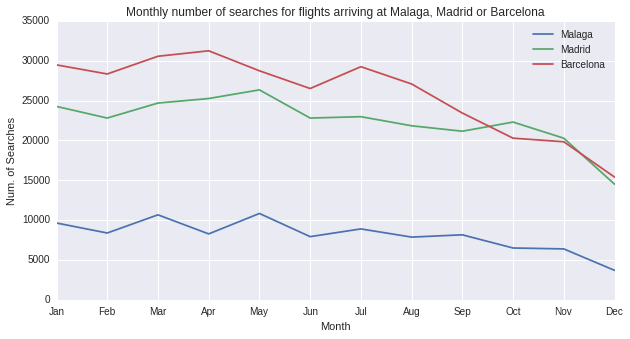

In [24]:
ax = dfSm.plot(figsize=(10, 5))
ax.set_xticks(dfSm.index)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_ylabel("Num. of Searches")
ax.set_title("Monthly number of searches for flights arriving at Malaga, Madrid or Barcelona")

---
# Fourth exercise
> *Match searches with bookings*

To find whether a search ended up in a booking or not, we will look for entries with matching:
- **Origin**
- **Destination**
- **Flight date**: features *brd_time* and *Seg1Date* in the bookings and searches datasets, respectively
- **Search/Booking date**: features *date* and *act_date* in the bookings and searches datasets, respectively

Notes:
- the feature *cre_date* in the bookings dataset could also be used as the date of the booking. Implementing that leads to a reduction of 33% in the number of matches.
- a possible improvement of these matching conditions would be to allow search dates to match bookings that happened within the next few days, instead of on the same day.

In [25]:
# unify column names for the matching:
new_col_names = ['Date_SearchBook', 'Origin','Destination', 'Date_Flight']
dfB.columns = new_col_names
dfS.columns = new_col_names
# drop the rows with null dates
dfS.dropna(inplace=True)
# remove spaces after aiport codes:
for col in ['Origin','Destination']:
    dfB[col] = dfB[col].apply(lambda x: x.strip())
    dfS[col] = dfS[col].apply(lambda x: x.strip())

We will obtain a new dataframe which is the intersection of the 2 datasets. However, we are only interested in the **indices**, because they correspond to the **row numbers of the matches in the searches dataset**.

In [26]:
dfS_Match = pd.merge(left=dfS, right=dfB, how='inner', on=new_col_names, right_index=True)
idx_S_matches = np.unique(dfS_Match.index.values)
print("We found %i matches (entries in searches dataset)." % len(idx_S_matches))

We found 37143 matches (entries in searches dataset).


Now we add a new field to the searches dataset with values:
- **0**: we found no booking matching this search :(
- **1**: the search ended up in a booking :)

and we store the updated dataset in a compressed csv file (searches_wB.csv.bz2) with the same format as the original one:

In [27]:
filepath = os.path.join(data_dir, data_files[1])
newfilepath = filepath[:-8] + '_match.csv.bz2'
# print first 4 rows as an example:
with bz2.BZ2File(filepath, 'rb') as or_file:
    for i,line in enumerate(or_file):
        if i==0:
            print line[:-1]+'^Booking\n'
        elif i==6:
            break
        else:
            print line[:-1]+'^1\n' if ((i-1) in idx_S_matches) else line[:-1]+'^0\n'
# write compressed file:
print("Writing file: %s...\n" % newfilepath)
print("(please be aware that it may take about 2h)")
with bz2.BZ2File(newfilepath, 'wb') as new_file, bz2.BZ2File(filepath, 'rb') as or_file:
    for i,line in enumerate(or_file):
        if i==0:
            new_file.write(line[:-1]+'^Booking\n')
        elif (i-1) in idx_S_matches:
            new_file.write(line[:-1] + '^1\n')
        else:
            new_file.write(line[:-1] + '^0\n')
print("...done")

Date^Time^TxnCode^OfficeID^Country^Origin^Destination^RoundTrip^NbSegments^Seg1Departure^Seg1Arrival^Seg1Date^Seg1Carrier^Seg1BookingCode^Seg2Departure^Seg2Arrival^Seg2Date^Seg2Carrier^Seg2BookingCode^Seg3Departure^Seg3Arrival^Seg3Date^Seg3Carrier^Seg3BookingCode^Seg4Departure^Seg4Arrival^Seg4Date^Seg4Carrier^Seg4BookingCode^Seg5Departure^Seg5Arrival^Seg5Date^Seg5Carrier^Seg5BookingCode^Seg6Departure^Seg6Arrival^Seg6Date^Seg6Carrier^Seg6BookingCode^From^IsPublishedForNeg^IsFromInternet^IsFromVista^TerminalID^InternetOffice^Booking

2013-01-01^20:25:57^MPT^624d8c3ac0b3a7ca03e3c167e0f48327^DE^TXL^AUH^1^2^TXL^AUH^2013-01-26^D2^^AUH^TXL^2013-02-02^D2^^^^^^^^^^^^^^^^^^^^^^1ASIWS^0^0^0^d41d8cd98f00b204e9800998ecf8427e^FRA^0

2013-01-01^10:15:33^MPT^b0af35b31588dc4ab06d5cf2986e8e02^MD^ATH^MIL^0^1^ATH^MIL^2013-01-04^^^^^^^^^^^^^^^^^^^^^^^^^^^^1ASIWS^0^0^0^d41d8cd98f00b204e9800998ecf8427e^KIV^0

2013-01-01^18:04:49^MPT^3561a60621de06ab1badc8ca55699ef3^US^ICT^SFO^1^2^ICT^SFO^2013-08-02^^^SFO^ICT